In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from glob import glob

sys.path.append('..')
import metaflux
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set_theme()
np.random.seed(101)
torch.manual_seed(101)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/user/anaconda3/envs/pytorch/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


## Load and modify your hyperparameters of your task

In [3]:
# Specify variables
ycolumn = "GPP_NT_VUT_REF"

# Load the hyperparameters for your task
config_path = '../metaflux/configs/hyperparams_1b.yaml'
hyper_args = metaflux.configs.get_hyperparams(config_path=config_path)

hyper_args['ycolumn'] = [ycolumn]
hyper_args['input_size'] = len(hyper_args['xcolumns'])

hyper_args

{'epoch': 100,
 'hidden_size': 350,
 'batch_size': 256,
 'input_size': 5,
 'meta_lr': 0.001,
 'update_lr': 0.0001,
 'meta_time_lr': 0.01,
 'update_time_lr': 0.001,
 'num_lstm_layers': 1,
 'max_meta_step': 2,
 'finetune_size': 0.2,
 'encoder_hidden_size': 64,
 'contextcolumns': ['Lat', 'Lon', 'PFT'],
 'xcolumns': ['P_ERA', 'LAI', 'VPD_ERA', 'TA_ERA', 'SW_IN_ERA'],
 'ycolumn': ['GPP_NT_VUT_REF']}

## Define dataloader

In [4]:
root_dir = '../metaflux/data/sample/'

# Note that the inputs are normalized here. For non-temporal data, we specify time_window = 1
fluxnet_train = metaflux.dataloader.Fluxmetanet(root=root_dir, mode="train", x_columns=hyper_args["xcolumns"], y_column=ycolumn, context_columns=hyper_args["contextcolumns"] , time_column="TIMESTAMP_START", time_window=30)
fluxnet_test = metaflux.dataloader.Fluxmetanet(root=root_dir, mode="test", x_columns=hyper_args["xcolumns"], y_column=ycolumn, context_columns=hyper_args["contextcolumns"], time_column="TIMESTAMP_START", time_window=30)

## Define your model

In [5]:
# Load model
model_type = "lstm" # currently supported models: ['lstm', 'bilstm', 'mlp']

# Metalearning without encoding and with baseline
model = metaflux.learner.Learner(
    input_size=hyper_args["input_size"], 
    hidden_size=hyper_args["hidden_size"], 
    model_type=model_type, 
    fluxnet_train=fluxnet_train,
    fluxnet_test=fluxnet_test,
    update_lr=hyper_args["update_lr"],
    meta_lr=hyper_args["meta_lr"],
    batch_size=hyper_args["batch_size"],
    max_meta_step=hyper_args["max_meta_step"],
    finetune_size=hyper_args["finetune_size"],
    encoder_hidden_size=hyper_args["encoder_hidden_size"],
    with_context=False,
    with_baseline=True
)

## Training and Evaluation

In [6]:
# Train metalearning models
runs = 5
model.train_meta(runs=runs, epochs=hyper_args["epoch"])

Baseline loss: 4.08 ± 0.03
Meta-learning without context loss: 3.43 ± 0.03


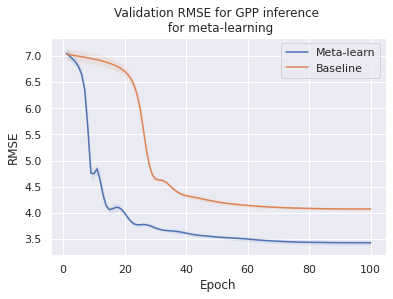

In [8]:
# Plot validation loss
is_smoothing = False
smoothing_exp = 7
f, ax = plt.subplots()
epochs = np.arange(1,hyper_args["epoch"] + 1)
meta_c_loss, meta_loss, base_loss = list(), list(), list()
for run in range(runs):
    meta_loss.append((model.meta_loss_metric[f"train_epoch_{run}"] + model.meta_loss_metric[f"val_epoch_{run}"]) / 2)
    base_loss.append((model.base_loss_metric[f"train_epoch_{run}"] + model.base_loss_metric[f"val_epoch_{run}"]) / 2)

meta_loss = np.array(meta_loss)
base_loss = np.array(base_loss)
if is_smoothing:
    meta_mean = np.poly1d(np.polyfit(epochs, meta_loss.mean(axis=0), smoothing_exp))(epochs)
    meta_std = np.poly1d(np.polyfit(epochs, meta_loss.std(axis=0), smoothing_exp))(epochs)
    base_mean = np.poly1d(np.polyfit(epochs, base_loss.mean(axis=0), smoothing_exp))(epochs)
    base_std = np.poly1d(np.polyfit(epochs, base_loss.std(axis=0), smoothing_exp))(epochs)
else:
    meta_mean = meta_loss.mean(axis=0)
    meta_std = meta_loss.std(axis=0)
    base_mean = base_loss.mean(axis=0)
    base_std = base_loss.std(axis=0)

ax.plot(epochs, meta_mean, label='Meta-learn')
ax.plot(epochs, base_mean, label='Baseline')
ax.fill_between(epochs, meta_mean - meta_std, meta_mean + meta_std, alpha=0.1)
ax.fill_between(epochs, base_mean - base_std, base_mean + base_std, alpha=0.1)
ax.set_title("Validation RMSE for GPP inference \n for meta-learning")
ax.set_ylabel("RMSE")
ax.set_xlabel("Epoch")
ax.legend()

print(f"Baseline loss: {min(base_loss.mean(axis=0)):.2f} ± {min(base_loss.std(axis=0)):.2f}")
print(f"Meta-learning without context loss: {min(meta_loss.mean(axis=0)):.2f} ± {min(meta_loss.std(axis=0)):.2f}")

f.savefig("../docs/gpp_infer.jpeg")